# Data Analysis of insulin process production

## Goal

Potential projects: Raman spectrometer soft sensor development, Faulty batches detection (before too late), 

## About the data:

The data was downloaded from [Kaggle](https://www.kaggle.com/datasets/stephengoldie/big-databiopharmaceutical-manufacturing/data). It consists of data for 100 batches of insulin, generated by [IndPenSim](http://www.industrialpenicillinsimulation.com/)

![Variables and Parameters](IndPenSim_input_outputs_V2.png) 


## References:

Goldrick S., Stefan, A., Lovett D., Montague G., Lennox B. (2015) The development of an industrial-scale fed-batch fermentation simulation Journal of Biotechnology, 193:70-82.

Goldrick S., Duran-Villalobos C., K. Jankauskas, Lovett D., Farid S. S, Lennox B., (2019) Modern day control challenges for industrial-scale fermentation processes. Computers and Chemical Engineering.

## 1 - Visualisation and cleaning

In [1]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import scipy.stats as stats

data = pd.read_csv('data/100_Batches_IndPenSim_V3.csv', usecols=range(39)) 
data_summary = pd.read_csv('data/100_Batches_IndPenSim_Statistics.csv')

In [2]:
data.describe()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag
count,113935.000000,113935.000000,113935.0,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,...,113935.0,2062.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000
mean,114.750656,65.246360,100.0,76.663764,0.073209,61.334389,74.346341,20.763025,154.811954,0.945026,...,0.0,51.546454,0.011024,0.301795,1.295783,50.402466,50.402466,0.101154,89307.003616,89402.127915
std,66.990504,11.690215,0.0,25.680134,0.552788,44.972713,108.022600,50.230266,155.601474,0.134269,...,0.0,24.073778,0.104415,0.459039,0.456396,28.862140,28.862140,0.301534,47765.751082,47852.683115
min,0.200000,20.000000,100.0,2.000000,0.000000,0.000000,0.000100,0.000100,0.000000,0.600000,...,0.0,4.075300,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,57.000000,60.000000,100.0,72.000000,0.000000,35.766000,11.157000,0.000100,0.000000,0.900000,...,0.0,34.812250,0.000000,0.000000,1.000000,26.000000,26.000000,0.000000,47016.500000,47029.500000
50%,114.000000,65.000000,100.0,80.000000,0.000000,55.407000,34.384000,0.159010,100.000000,0.900000,...,0.0,53.154000,0.000000,0.000000,1.000000,50.000000,50.000000,0.000000,89699.000000,89772.000000
75%,171.000000,75.000000,100.0,90.000000,0.000000,76.271500,94.904500,11.640500,250.000000,1.100000,...,0.0,73.536000,0.000000,1.000000,2.000000,76.000000,76.000000,0.000000,129390.000000,129570.000000
max,290.000000,75.000000,100.0,150.000000,12.996000,225.000000,1500.000000,1500.000000,500.000000,1.100000,...,0.0,117.930000,1.000000,1.000000,2.000000,100.000000,100.000000,1.000000,194630.000000,195340.000000


In [3]:
data.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'Oil flow(Foil:L/hr)',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicil

In [4]:
# Rewrites Batch ID's correctly
data = data.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference', # Mistaken attribution
                            'Batch reference(Batch_ref:Batch ref)':'Faulty batch', # Mistaken attribution + seems to indicate if a batch is faulty
                            })

# Drop superfluous/unusable columns
data.drop([' 1-Raman spec recorded'], axis=1, inplace=True) # I don't see the point of this column, seems to be a duplicate of Batch reference
data.drop(['Batch ID'], axis=1, inplace=True) # Mysterious column; is not actually a batch ID, closely follows penicilin concentration
data.drop(['Fault flag'], axis=1, inplace=True) # Mysterious column; is not actually a binary flag, closely follows penicilin concentration

# Changes the ID of the columns for more comprehensive names
data = data.rename(columns={'0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)':'Operator controlled',
                            'Fault reference(Fault_ref:Fault ref)':'Faulty measure'})

# Correct data readability for a categorical (binary) variable:
data = data.rename(columns={'1- No Raman spec': 'Raman spec recorded'})
data['Raman spec recorded'] = data['Raman spec recorded'] - 1

# Creates a copy of the data so that the plot in the following cell can stay interactive
copy_data = data.copy(deep=True)

In [5]:
variable_list = data.columns
variable_plot_selection = widgets.Dropdown(options=variable_list, value = 'Penicillin concentration(P:g/L)')
variable_plot_selection

Dropdown(index=13, options=('Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)', 'Sugar feed rate(Fs:…

Text(0, 0.5, 'Oxygen in percent in off-gas(O2:O2  (%))')

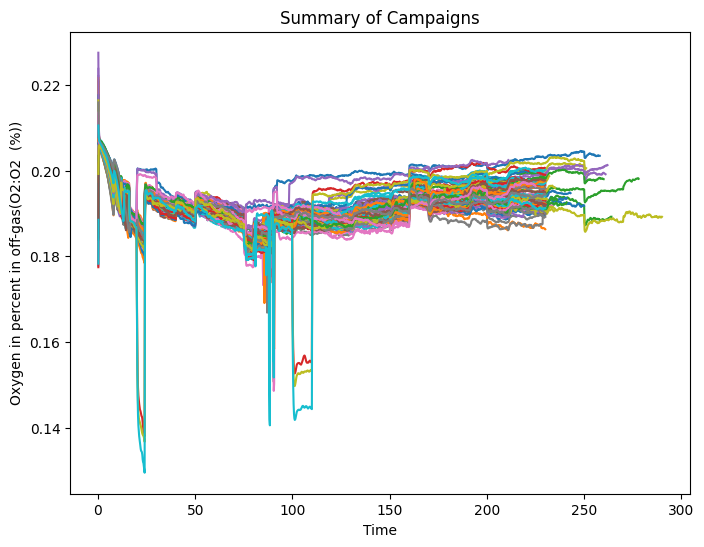

In [120]:
fig, ax = plt.subplots(figsize=(8,6))
bp = copy_data.groupby('Batch reference').plot(x = 'Time (h)', y = variable_plot_selection.value,   ax=ax, legend = False, )
ax.set_title('Summary of Campaigns')
ax.set_xlabel('Time')
ax.set_ylabel(variable_plot_selection.value)

Important observation: Most batches have a duration of 230h, but some last for slightly longer/shorter times.

- Agitation: Always 100RPM, not useful
- Water for injection/dilution: Same trajectory for all batches
- Air head pressure: Same trajectory for all batches
- Dumped broth flow: Same trajectory for all batches
- Ammonia shots: Same trajectory for all batches
- PAA concentration offline does not show any data on the plot => because taken every 4 hours
- NH3 concentration offline does not show any data on the plot => because taken every 4 hours
- Penicilin concentration offline does not show any data on the plot => because taken every 4 hours
- Biomass concentration offline does not show any data on the plot => because taken every 4 hours
- Viscosity offline does not show any data on the plot => because taken every 4 hours
- What is Batch ID? Seems to be a numerical value related to peniciline concentration
- What is Fault flag? Seems to be a numerical value related to peniciline concentration

//

- Vessel weight and vessel volume should be highly correlated
- Generated heat, oxygen uptake rate and CO2% in outlet should be highly correlated


Some features in the data are there because the data comes from a bioprocess simulation; in reality, these features cannot be measured properly. These features are: 
- On-line Penicillin concentration (We assume we do not have a Raman spectrometer in the tank)
- 

In [7]:
# Drop columns with constant values:
data.drop(['Agitator RPM(RPM:RPM)', 'Ammonia shots(NH3_shots:kgs)'], axis=1, inplace=True)

In [8]:
# Check for missing data:
missing_data = data.isnull().sum()
print(missing_data)

Time (h)                                                        0
Aeration rate(Fg:L/h)                                           0
Sugar feed rate(Fs:L/h)                                         0
Acid flow rate(Fa:L/h)                                          0
Base flow rate(Fb:L/h)                                          0
Heating/cooling water flow rate(Fc:L/h)                         0
Heating water flow rate(Fh:L/h)                                 0
Water for injection/dilution(Fw:L/h)                            0
Air head pressure(pressure:bar)                                 0
Dumped broth flow(Fremoved:L/h)                                 0
Substrate concentration(S:g/L)                                  0
Dissolved oxygen concentration(DO2:mg/L)                        0
Penicillin concentration(P:g/L)                                 0
Vessel Volume(V:L)                                              0
Vessel Weight(Wt:Kg)                                            0
pH(pH:pH) 

## 2 - Multiway PCA

We are going to apply PCA on the data, to visualize the data and see if we can detect the "good" and the "bad" batches before they end. To do this, we are going to unfold the data, so that we have a row for each batch and a column for every parameter at every time point. It means that every parameter at every timepoint are vectors orthogonal to each other.

In [9]:
# Only keep data from the campaign 4 (same as in the paper): Fixed duration, recipe driven
data = data[data['Operator controlled'] == 0]
data = data[data['Raman spec recorded'] == 0] # Raman spec controlled batches are also marked as "recipe driven"
grouped = data.groupby('Batch reference')
filtered_groups = [group for name, group in grouped if len(group) == 1150] # Only keep 230h long batches

data = pd.concat(filtered_groups)
del grouped, filtered_groups

# Drop columns with discrete/categorical variables:
data.drop(['Faulty measure',
           'Operator controlled',
           'Raman spec recorded'],
            axis=1, inplace=True)

# Drop columns with delayed measurements (offline) and values provided by the Raman spectrometer:
data.drop(['PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
           'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
           'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
           'Viscosity(Viscosity_offline:centPoise)',
           'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
           'Substrate concentration(S:g/L)',
           'Penicillin concentration(P:g/L)'], axis=1, inplace=True)

In [10]:
data.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Dissolved oxygen concentration(DO2:mg/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))', 'Oil flow(Foil:L/hr)',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Carbon evolution rate(CER:g/h)', 'Batch reference', 'Faulty batch'],
      dtype='object')

In [11]:
data = data.sort_values(by=['Batch reference', 'Time (h)'])
filtered_operator_driven_data = data # We save this for the later Fourier analysis

# Pivot the DataFrame
variable_names = list(set(data.columns.to_list()) - set('Time (h)'))
data = data.pivot_table(index='Batch reference', columns='Time (h)', values=variable_names)

# Flatten the MultiIndex columns:
data.columns = [f'{var}_t{time}' for var, time in data.columns]

# We keep only one "Faulty batch" column:
columns_to_drop = data.filter(regex="^Faulty batch").columns
data = data.drop(columns_to_drop[1:], axis=1)
data = data.rename(columns={"Faulty batch_t0.2": "Faulty batch"})
del columns_to_drop

data

,Acid flow rate(Fa:L/h)_t0.2,Acid flow rate(Fa:L/h)_t0.4,Acid flow rate(Fa:L/h)_t0.6,Acid flow rate(Fa:L/h)_t0.8,Acid flow rate(Fa:L/h)_t1.0,Acid flow rate(Fa:L/h)_t1.2,Acid flow rate(Fa:L/h)_t1.4,Acid flow rate(Fa:L/h)_t1.6,Acid flow rate(Fa:L/h)_t1.8,Acid flow rate(Fa:L/h)_t2.0,...,pH(pH:pH)_t228.2,pH(pH:pH)_t228.4,pH(pH:pH)_t228.6,pH(pH:pH)_t228.8,pH(pH:pH)_t229.0,pH(pH:pH)_t229.2,pH(pH:pH)_t229.4,pH(pH:pH)_t229.6,pH(pH:pH)_t229.8,pH(pH:pH)_t230.0
Batch reference,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.00000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,...,6.5018,6.5045,6.5058,6.5052,6.5024,6.4981,6.4975,6.4982,6.5007,6.5040
4,0.0,0.0,0.00000,0.0000,0.51779,1.03850,1.5602,0.0000,0.0000,0.0000,...,6.5003,6.5055,6.5091,6.5096,6.5063,6.5011,6.4963,6.4937,6.4932,6.4961
6,0.0,0.0,0.00000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,...,6.5040,6.4997,6.4964,6.4951,6.4954,6.4968,6.4986,6.5009,6.5043,6.5064
8,0.0,0.0,0.00000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,...,6.5080,6.5090,6.5094,6.5083,6.5063,6.5014,6.4973,6.4915,6.4894,6.4911
10,0.0,0.0,0.00000,0.0000,0.51520,1.03320,1.5539,2.0759,2.5982,3.1205,...,6.5031,6.4966,6.4923,6.4912,6.4943,6.5009,6.5075,6.5097,6.5092,6.5057
12,0.0,0.0,0.00000,0.0000,0.00000,0.52105,0.0000,0.0000,0.0000,0.0000,...,6.5033,6.5006,6.4985,6.4980,6.4982,6.4973,6.4975,6.4964,6.4987,6.5020
14,0.0,0.0,0.00000,0.0000,0.51498,1.03270,1.5532,2.0748,2.5970,3.1192,...,6.4983,6.5048,6.5076,6.5089,6.5076,6.5049,6.5019,6.4980,6.4964,6.4955
16,0.0,0.0,0.00000,0.0000,0.51595,1.03560,1.5569,2.0790,2.6012,0.0000,...,6.4942,6.4956,6.4993,6.5042,6.5077,6.5094,6.5074,6.5009,6.4950,6.4919
18,0.0,0.0,0.52266,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,0.0000,...,6.5083,6.5058,6.5008,6.4964,6.4943,6.4959,6.5002,6.5050,6.5079,6.5073


In [12]:
# Removes columns with standard deviation of 0, not useful for prediction
# We are able to drop around 40% of the columns!
data = data.loc[:, data.std() != 0]

# Normalization
columns_to_normalize = data.columns.difference(['Faulty batch'])
data[columns_to_normalize] = (data[columns_to_normalize] - data[columns_to_normalize].mean()) / data[columns_to_normalize].std()

NOC_batches = data[data['Faulty batch'] == 0].drop("Faulty batch", axis=1)
faulty_batches = data[data['Faulty batch'] == 1].drop("Faulty batch", axis=1)
del data

# PCA
pca = PCA()
pca.fit(NOC_batches) # Fit with only NOC batches

explained_variance_ratio = pca.explained_variance_ratio_
print("Cumulative explained variance:", explained_variance_ratio.cumsum())

/tmp/ipykernel_121624/2165469807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = (data[columns_to_normalize] - data[columns_to_normalize].mean()) / data[columns_to_normalize].std()


Cumulative explained variance: [0.27067106 0.44108346 0.54882787 0.63452408 0.69432112 0.75258871
 0.79930318 0.83980524 0.87889517 0.90839008 0.93693013 0.96217721
 0.98269808 1.         1.        ]


We can see that around 80% of the variance can be explained by 7 components. We are going to use the first 7 PC to describe the data.

In [13]:
nb_PC = 7
PCA_statistics = pd.DataFrame(columns=['Batch reference', 'Q stat', 'Q threshold', 'T2 stat', 'T2 threshold', 'Faulty batch'])
loo=LeaveOneOut()

for i, (train_index, test_index) in enumerate(loo.split(NOC_batches)):
    # Use .iloc to index by position
    train_data = NOC_batches.iloc[train_index]
    test_data = NOC_batches.iloc[test_index]
    
    # Initialize and fit the PCA model to retreive 
    # all the eigenvalues of the covariance matrix
    pca = PCA()
    pca.fit(train_data)
    #eigenvalues_corr_matrix = pca.explained_variance_ratio_
    eigenvalues_cov_matrix = pca.explained_variance_
    eigenvalues_retained_PC = eigenvalues_cov_matrix[:nb_PC]
    eigenvalues_discarded_PC = eigenvalues_cov_matrix[nb_PC:]
    
    # re_fit the PCA (ugly, but only way to have all eigenvalues 
    # AND projecting on a subset of PC)
    pca = PCA(n_components=nb_PC)
    pca.fit(train_data)
    
    # Transform the data
    test_data_transformed = pca.transform(test_data)
    train_data_transformed = pca.transform(train_data)
    faulty_batches_transformed = pca.transform(faulty_batches)
    
    # Reconstruct the data from the PCA model
    test_data_reconstructed = pca.inverse_transform(test_data_transformed)
    train_data_reconstructed = pca.inverse_transform(train_data_transformed)
    faulty_batches_reconstructed = pca.inverse_transform(faulty_batches_transformed)
    
    alpha = 0.05
    
    # Compute the Q statistic (sum of squared residuals)
    residuals_test_data = test_data - test_data_reconstructed
    residuals_faulty_batches = faulty_batches - faulty_batches_reconstructed
    Q_statistic_test_data = float(np.sum(residuals_test_data ** 2, axis=1).iloc[0])
    
    Q_statistics_faulty_batches = []
    for index, f_batch_df in residuals_faulty_batches.iterrows():
        f_batch = f_batch_df.to_numpy()
        Q_statistic_faulty_batch = np.sum(f_batch ** 2)
        Q_statistics_faulty_batches.append(Q_statistic_faulty_batch)
    
    # Compute the 95% confidence treshold for the Q statistic:
    residuals_train_data = train_data - train_data_reconstructed
    theta_1 = np.sum(eigenvalues_discarded_PC)
    theta_2 = np.sum(eigenvalues_discarded_PC**2)
    g_SPE = theta_2/theta_1
    h_SPE = (theta_1**2)/theta_2
    Q_threshold = g_SPE*stats.chi2.ppf(1 - alpha, h_SPE)
    
    # Compute the Hostelling T² statistic (Mahalanobis distance between origin and scores)
    T2_statistic_test_data = np.sum((test_data_transformed[0] ** 2) / eigenvalues_retained_PC)
    
    T2_statistics_faulty_batches = []
    for f_batch in faulty_batches_transformed:
        T2_statistic_faulty_batch = np.sum((f_batch ** 2) / eigenvalues_retained_PC)
        T2_statistics_faulty_batches.append(T2_statistic_faulty_batch)

    # Compute the 95% confidence treshold for the T² statistic:
    R = nb_PC
    I = len(train_index)
    T2_threshold = R*(I-1)/(I-R) * stats.f.ppf(1-alpha, R, I-R)
    
    # Store the results
    stats_test_row = pd.DataFrame({'Batch reference':[test_data.index[0]], 
                                   'Q stat': [Q_statistic_test_data],
                                   'Q threshold': [Q_threshold],
                                   'T2 stat': [T2_statistic_test_data],
                                   'T2 threshold': [T2_threshold],
                                   'Faulty batch': [0]})
    
    stats_faulty_batches_rows = pd.DataFrame({'Batch reference':faulty_batches.index.to_list(), 
                                   'Q stat': Q_statistics_faulty_batches,
                                   'Q threshold': [Q_threshold]*len(faulty_batches),
                                   'T2 stat': T2_statistics_faulty_batches,
                                   'T2 threshold': [T2_threshold]*len(faulty_batches),
                                   'Faulty batch': [1]*len(faulty_batches)})
    
    PCA_statistics = pd.concat([PCA_statistics, stats_test_row, stats_faulty_batches_rows], ignore_index=True)
    #PCA_statistics = pd.concat([PCA_statistics, stats_faulty_batches_rows], ignore_index=True)

/tmp/ipykernel_121624/3287023764.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  PCA_statistics = pd.concat([PCA_statistics, stats_test_row, stats_faulty_batches_rows], ignore_index=True)


We can now visualize the results. Let's see if batch outcome can be predicted from the whole time series of the process variables : 

[]

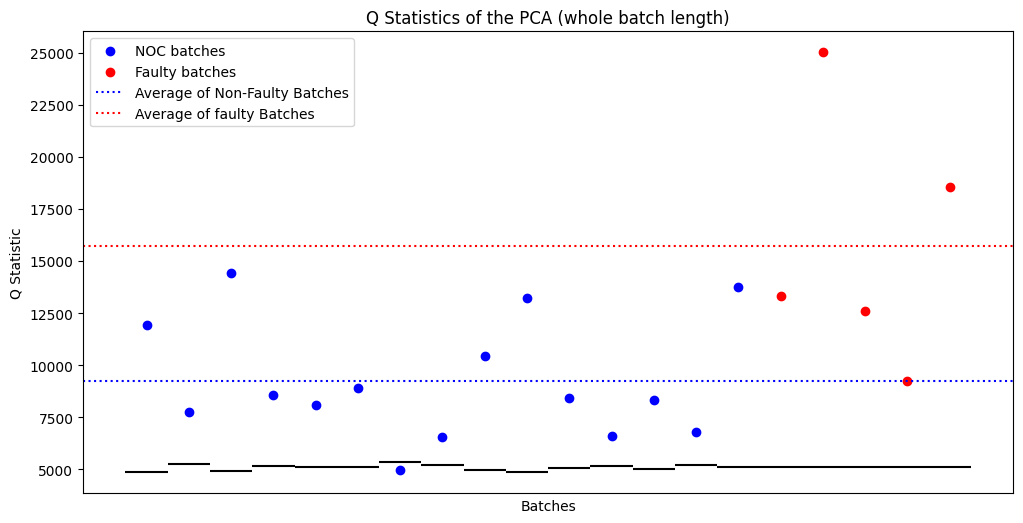

In [14]:
averaged_stats = PCA_statistics.groupby(['Batch reference']).mean()
averaged_stats = averaged_stats.reset_index(drop=True)

# Plot Q statistics
plt.figure(figsize=(12, 6))
for i in range(len(averaged_stats)):
    if averaged_stats['Faulty batch'].iloc[i] == 1.0:
        plt.scatter(averaged_stats.index[i], 
                    averaged_stats['Q stat'].iloc[i], 
                    color='red', 
                    label='Faulty batches' if i == averaged_stats[averaged_stats['Faulty batch']==1].iloc[0].name \
                    else "")
    else:
        plt.scatter(averaged_stats.index[i], 
                    averaged_stats['Q stat'].iloc[i], 
                    color='blue', 
                    label='NOC batches' if i == averaged_stats[averaged_stats['Faulty batch']==0].iloc[0].name \
                    else "")
    
    # Plot thresholds
    plt.hlines(y=averaged_stats['Q threshold'].iloc[i], 
               xmin=averaged_stats.index[i] - 0.5, 
               xmax=averaged_stats.index[i] + 0.5, 
               color='black', 
               linestyles='solid'),
               #label='95% significance threshold')

    
# Calculate the average of the blue and red points
average_blue = averaged_stats[averaged_stats['Faulty batch'] == 0.0]['Q stat'].mean()
average_red = averaged_stats[averaged_stats['Faulty batch'] == 1.0]['Q stat'].mean()

# Add a horizontal blue line at the average height of the blue points
plt.axhline(y=average_blue, color='blue', linestyle='dotted', label='Average of Non-Faulty Batches')
plt.axhline(y=average_red, color='red', linestyle='dotted', label='Average of faulty Batches')
    
# Labeling the plot
plt.xlabel('Batches')
plt.ylabel('Q Statistic')
plt.title('Q Statistics of the PCA (whole batch length)')
plt.xticks(averaged_stats.index)  # Set x-ticks to batch references
plt.legend()

# Hide Y axes label marks
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.set_xticks([])

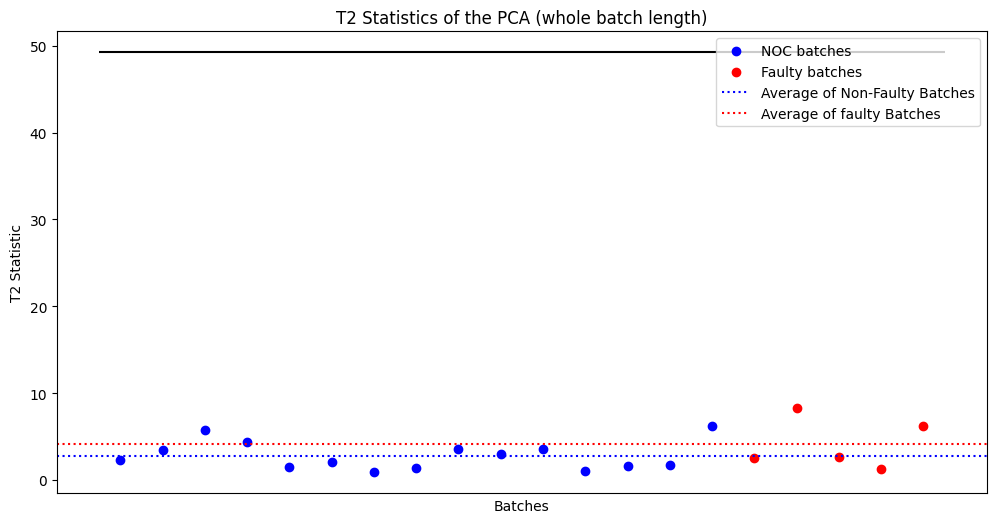

In [15]:
# Plot T2 statistics:
plt.figure(figsize=(12, 6))
for i in range(len(averaged_stats)):
    if averaged_stats['Faulty batch'].iloc[i] == 1.0:
        plt.scatter(averaged_stats.index[i], 
                    averaged_stats['T2 stat'].iloc[i], 
                    color='red', 
                    label='Faulty batches' if i == averaged_stats[averaged_stats['Faulty batch']==1].iloc[0].name \
                    else "")
    else:
        plt.scatter(averaged_stats.index[i], 
                    averaged_stats['T2 stat'].iloc[i], 
                    color='blue', 
                    label='NOC batches' if i == averaged_stats[averaged_stats['Faulty batch']==0].iloc[0].name \
                    else "")
    
    # Plot thresholds
    plt.hlines(y=averaged_stats['T2 threshold'].iloc[i], 
               xmin=averaged_stats.index[i] - 0.5, 
               xmax=averaged_stats.index[i] + 0.5, 
               color='black', 
               linestyles='solid')
               #label='95% significance threshold')

    
# Calculate the average of the blue and red points
average_blue = averaged_stats[averaged_stats['Faulty batch'] == 0.0]['T2 stat'].mean()
average_red = averaged_stats[averaged_stats['Faulty batch'] == 1.0]['T2 stat'].mean()

# Add a horizontal blue line at the average height of the blue points
plt.axhline(y=average_blue, color='blue', linestyle='dotted', label='Average of Non-Faulty Batches')
plt.axhline(y=average_red, color='red', linestyle='dotted', label='Average of faulty Batches')
    
# Labeling the plot
plt.xlabel('Batches')
plt.ylabel('T2 Statistic')
plt.title('T2 Statistics of the PCA (whole batch length)')
plt.xticks(averaged_stats.index)  # Set x-ticks to batch references
plt.legend()

# Hide Y axes label marks
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.set_xticks([])

# Show the plot
plt.show()

We can observe the following two things:

1) The Q statistics are almost all above the 95% confidence threshold and the T2 statistics are all below the confidence threshold regardless of the batch quality. It seems that the tests fail to capture the quality of the batches.

2) The mean statistics (Q and T²) of the NOC batches are slightly lower than the faulty batches. The difference may or may not be significant, we don't have enough data to test it.

In the original paper by Goldrick & al., the authors show that the T² statistic fails to capture the batch quality, as the 95% confidence threshold is never attained by any batch, faulty or not. They highlight that previous research has found the T2 statistic to underestimate faults. \\

Their Q-statistic plot however looks different. All batches are correctly classified as faulty or NOC by the 95% confidence limit, which contrasts to our plot. Goldrick & al constructed the Q-statistic plot by showing the Q-statistic of batches used to create the PCA in the first place. This approach is misleading, as it does not check the prediction accuracy of the test; it's like formulating a hypothesis and validating it with the same data. We tested our PCA with cross-validation, in a way that reflects how newly recorded batches would compare against the PCA model. These results show that the PCA model is likely overfitting the data. This is not really surprising, as there are only 15 NOC batches and thousands of variables. So, what could we do to avoid this overfitting problem?

1) Use less variables: If a fault happens in the process after 200 hours, it is more likely that the first hours of the process are not the cause of this effect. The cause-to-effect time should be limited by a certain value. This means that we can use data only from the last X measures of the process to detect faults, in a moving window manner. It would avoid adding unnecessary variables to the PCA model that most likely contain NOC data anyway.

2) Normalize the data differently: Some variables have variability over time heavily influenced by noise. We can guess that based on our mechanistic understanding of the process. For example, recorded temperature should be pretty uniform, high frequency changes are noise that we do not want to have in our PCA model. To avoid that, we could apply a smoothing function to the data, or use a low-pass filter. The method of choice has to be applicable in real time, since we want real-time monitoring of the process.

## 3 - Fourier Analysis 

In [16]:
# Compute the DFT for each batch:
grouped_batches = filtered_operator_driven_data.groupby('Batch reference')
fourier_all_operator_batches = []
for name, batch in grouped_batches:
    N = len(batch)
    raw_fourier_batch = np.abs(np.fft.fft(batch.to_numpy(), axis=0))/N # Get the amplitude of the signal
    fourier_operator_batch = pd.DataFrame(raw_fourier_batch, columns=filtered_operator_driven_data.columns)
    fourier_operator_batch['Batch reference'] = batch['Batch reference'].reset_index(drop=True)
    fourier_operator_batch['Faulty batch'] = batch['Faulty batch'].reset_index(drop=True)
    fourier_operator_batch['Frequency (1/h)'] = np.fft.fftfreq(len(batch), d=0.2)
    fourier_all_operator_batches.append(fourier_operator_batch)
    
fourier_all_operator_batches = pd.concat(fourier_all_operator_batches)
fourier_all_operator_batches.drop(['Time (h)'], axis=1, inplace=True)
fourier_all_operator_batches = fourier_all_operator_batches.sort_values(by=['Batch reference', 'Frequency (1/h)'])
fourier_all_operator_batches.reset_index(drop=True, inplace=True)

# Removing the DC components out of the Fourier transforms:
columns_to_modify = fourier_all_operator_batches.columns.difference(['Frequency (1/h)', 'Batch reference', 'Faulty batch'])
fourier_all_operator_batches.loc[fourier_all_operator_batches['Frequency (1/h)'] == 0, columns_to_modify] = 0
fourier_all_operator_batches

,Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Dissolved oxygen concentration(DO2:mg/L),...,Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h),Batch reference,Faulty batch,Frequency (1/h)
0,4.159119e-18,0.006087,0.000001,0.025770,0.076548,0.760783,0.347826,0.000087,2.423537e-15,0.002726,...,0.278257,0.000818,0.004348,2.071747e-17,0.000028,1.739130e-07,0.000506,2,0,-2.500000
1,1.812399e-02,0.028415,0.002144,0.019589,0.291124,0.866326,0.345460,0.000115,3.255181e-01,0.002876,...,0.445549,0.000587,0.006682,7.828456e-03,0.000156,6.968253e-06,0.000547,2,0,-2.495652
2,1.024374e-02,0.030834,0.002121,0.030092,0.542569,0.532185,0.426385,0.000196,1.198859e-01,0.001120,...,0.306483,0.000692,0.006744,9.508836e-03,0.000252,5.528815e-06,0.000522,2,0,-2.491304
3,1.853488e-02,0.019582,0.001798,0.007459,0.694538,1.523002,0.233313,0.000235,1.658817e-01,0.000659,...,0.753742,0.000780,0.001926,4.250391e-03,0.000018,5.880952e-06,0.000517,2,0,-2.486957
4,1.785583e-02,0.029679,0.001726,0.015300,0.236309,1.209439,0.141326,0.000117,4.395487e-01,0.000196,...,0.500132,0.000534,0.004769,3.222345e-03,0.000530,1.187160e-05,0.000545,2,0,-2.482609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22995,4.881451e-02,0.049577,0.010722,0.045659,1.426328,2.270076,0.225184,0.000148,2.272337e-01,0.004232,...,1.449617,0.002040,0.007680,6.275282e-03,0.001675,1.708443e-05,0.000690,100,1,2.478261
22996,2.637454e-02,0.029679,0.009145,0.092442,1.148399,1.057427,0.141326,0.000117,4.395487e-01,0.003911,...,0.617280,0.002057,0.004769,3.222345e-03,0.000825,1.660497e-05,0.000583,100,1,2.482609
22997,7.967399e-02,0.019582,0.007600,0.092457,0.699932,1.183927,0.233313,0.000235,1.658817e-01,0.006367,...,0.560688,0.002832,0.001926,4.250391e-03,0.001132,5.029386e-05,0.000985,100,1,2.486957
22998,3.744742e-02,0.030834,0.003098,0.061686,0.374489,0.247360,0.426385,0.000196,1.198859e-01,0.006058,...,0.167558,0.003137,0.006744,9.508836e-03,0.000463,3.562309e-05,0.000306,100,1,2.491304


In [17]:
variable_list_2 = fourier_all_operator_batches.columns
variable_plot_selection_2 = widgets.Dropdown(options=variable_list_2, value = 'Temperature(T:K)')
variable_plot_selection_2

Dropdown(index=13, options=('Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)', 'Bas…

Text(0, 0.5, 'Temperature(T:K)')

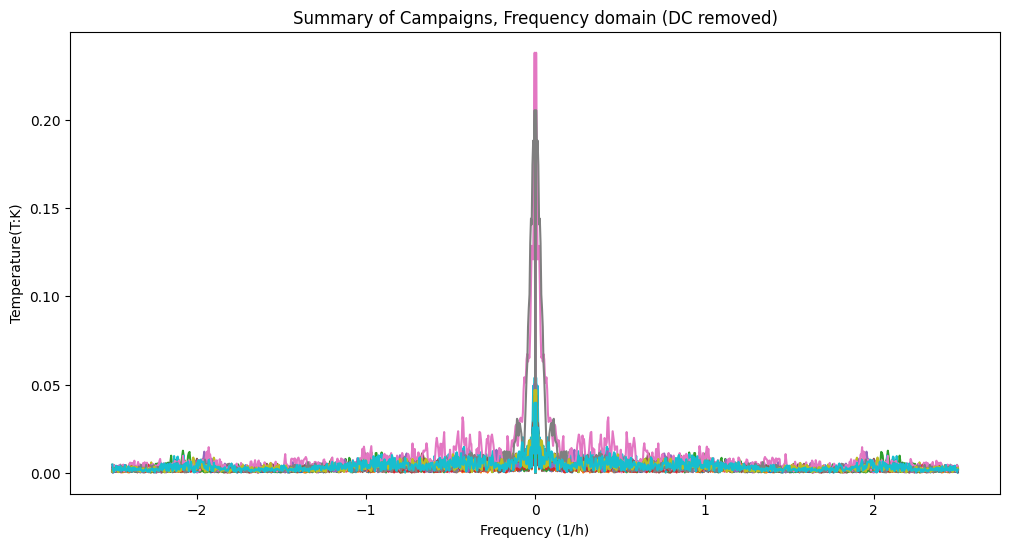

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
bp = fourier_all_operator_batches.groupby('Batch reference').plot(x = 'Frequency (1/h)', y = variable_plot_selection_2.value,   ax=ax, legend = False, )
ax.set_title('Summary of Campaigns, Frequency domain (DC removed)')
ax.set_xlabel('Frequency (1/h)')
ax.set_ylabel(variable_plot_selection_2.value)

## 4 - Correlation Analysis

The time series are heavily correlated one with the other. We leverage this fact to reduce dimensionality with PCA. Now, we want to have a closer look at the correlation structure of the process. This will help us find the size of the temporal window we are going to use to construct PCA with less variables (and hopefully, better detection of faulty batches).

Lagged Cross-Correlation Matrix:

For each lag ll, compute a cross-correlation matrix C(l)C(l), which contains correlations between each pair of variables at time tt and t−lt−l. Summarize C(l)C(l) to a single measure, such as the average cross-correlation or maximum cross-correlation across all pairs. This will give you a measure of how much variables are correlated with their past values at each lag ll.

The triangle comes from the fact that I have a BIASED correlation: points at the beginning and end of the series have less data to be evaluated. The triangular shape happens when there is a biased (0-padded, or finite) correlation between signals. To remove this triangular shape, one can simply remove the DC component/ the offset of the signals.

In [134]:
# Autocorrelation plot:
# I am going to see correlations, but the more shifted they are, the less meaningful they are.
# Maybe this does not help with finding the size of the temporal window?
autocorrelated_all_operator_batches = list()
for name, batch in grouped_batches:
    # Compute the cross-correlation of the series with itself: (Could also use the Fourier transforms from above)
    mean_1 = batch['Oxygen Uptake Rate(OUR:(g min^{-1}))'].mean()
    mean_2 = batch['Oxygen in percent in off-gas(O2:O2  (%))'].mean()
    autocorrelation = np.convolve(batch['Oxygen Uptake Rate(OUR:(g min^{-1}))'] - mean_1, 
                                  batch['Oxygen in percent in off-gas(O2:O2  (%))'].iloc[::-1] - mean_2)
    # Normalize the result
    autocorrelation = autocorrelation / (np.linalg.norm(batch['Oxygen Uptake Rate(OUR:(g min^{-1}))']) \
                                         * np.linalg.norm(batch['Oxygen in percent in off-gas(O2:O2  (%))']))
    autocorr_operator_batch = pd.Series(autocorrelation)
    autocorrelated_all_operator_batches.append(autocorr_operator_batch)

autocorrelated_all_operator_batches = pd.concat(autocorrelated_all_operator_batches, axis=1)
n = len(autocorrelated_all_operator_batches)
autocorrelated_all_operator_batches['time shift'] = np.arange(-n // 2, n // 2)

In [146]:
variable_list_3 = autocorrelated_all_operator_batches.columns
variable_plot_selection_3 = widgets.Dropdown(options=variable_list_3)
variable_plot_selection_3

Dropdown(options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'time shift'), value=0…

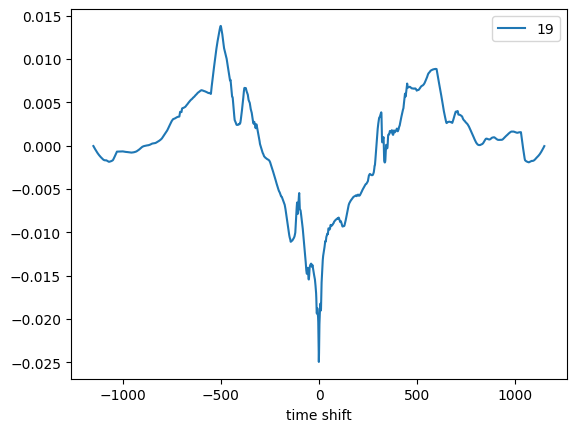

In [156]:
autocorrelated_all_operator_batches.plot(x='time shift', y=variable_plot_selection_3.value)
ax.set_xlabel('cross-autocorrelation')
ax.set_ylabel(variable_plot_selection_3.value)

plt.show()